In [2]:
# Everday libraries:
import re
import numpy as np
import pandas as pd # reads csv datasets

# Libraries for processing text:
import langdetec # detects the language of text
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer # converts text to numerical values
from tensorflow.keras.preprocessing.sequence import pad_sequences # adds zeros on the end of sentences to keep consistent length
from sklearn.model_selection import train_test_split # splits the dataframe into three sets
from sklearn.preprocessing import OneHotEncoder # encodes the sentiment labels into three distinct columns
import warnings # removes warning messages

# Filter out FutureWarnings:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.preprocessing._encoders")

# Creating the LSTM model:
import optuna # optimizes hyperparameters
from keras.models import Sequential # the type of RNN model
from keras.layers import Embedding, LSTM, Dropout, Dense # the different layers that are used in an RNN
from sklearn.utils.class_weight import compute_class_weight # creates a weight to assign to the sentiment class

# Evaluating the model
import matplotlib.pyplot as plt # for visualizations
from sklearn.metrics import classification_report, confusion_matrix # help evaluate the model through accuracy score, recall etc
import tkinter as tk # developes a GUI
from tkinter import messagebox # developed a textbox widget in the GUI
from keras.models import load_model # loads the saved LSTM model into the notebook

## Import and read datasets

In [3]:
# Read both dataframes with pandas
df1 = pd.read_csv('reviews.csv')
df2 = pd.read_csv('offerings.csv')

## Pre-processing

In [4]:
# Display top 5 rows
df1.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,2012-12-17,147643103,False
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,2012-12-17,147639004,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",December 2012,1762573,0,2012-12-18,147697954,False
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",August 2012,1762573,0,2012-12-17,147625723,False
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",December 2012,1762573,0,2012-12-17,147612823,False


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878561 entries, 0 to 878560
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ratings            878561 non-null  object
 1   title              878561 non-null  object
 2   text               878561 non-null  object
 3   author             878561 non-null  object
 4   date_stayed        810967 non-null  object
 5   offering_id        878561 non-null  int64 
 6   num_helpful_votes  878561 non-null  int64 
 7   date               878561 non-null  object
 8   id                 878561 non-null  int64 
 9   via_mobile         878561 non-null  bool  
dtypes: bool(1), int64(3), object(6)
memory usage: 61.2+ MB


In [6]:
# Display top 5 rows
df2.head()

,hotel_class,region_id,url,phone,details,address,type,id,name
0,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '147 West 4...",hotel,113317,Casablanca Hotel Times Square
1,5.0,32655,http://www.tripadvisor.com/Hotel_Review-g32655...,NaN,NaN,"{'region': 'CA', 'street-address': '300 S Dohe...",hotel,76049,Four Seasons Hotel Los Angeles at Beverly Hills
2,3.5,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '790 Eighth...",hotel,99352,Hilton Garden Inn Times Square
3,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '152 West 5...",hotel,93589,The Michelangelo Hotel
4,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '130 West 4...",hotel,217616,The Muse Hotel New York


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hotel_class  3141 non-null   float64
 1   region_id    4333 non-null   int64  
 2   url          4333 non-null   object 
 3   phone        0 non-null      float64
 4   details      0 non-null      float64
 5   address      4333 non-null   object 
 6   type         4333 non-null   object 
 7   id           4333 non-null   int64  
 8   name         4333 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 304.8+ KB


In [8]:
# Determine the number of rows and columns
df1.shape 

(878561, 10)

In [9]:
# Determine the number of rows and columns
df2.shape 

(4333, 9)

In [10]:
# There are some columns that are not needed for sentiment analysis, we need to drop them.
columns_to_drop = ['author', 'date_stayed', 'num_helpful_votes', 'date', 'id', 'via_mobile']
df1_drop = df1.drop(columns=columns_to_drop)

In [11]:
# Check the columns have been dropped
df1_drop.head()

,ratings,title,text,offering_id
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,93338
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",93338
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,1762573
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,1762573
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,1762573


In [12]:
# Need to drop columns in df2 as well
columns_to_drop = ['hotel_class', 'region_id', 'url', 'phone', 'details', 'address', 'type']
df2_drop = df2.drop(columns=columns_to_drop)

In [13]:
# Check the columns have been dropped
df2_drop.head()

,id,name
0,113317,Casablanca Hotel Times Square
1,76049,Four Seasons Hotel Los Angeles at Beverly Hills
2,99352,Hilton Garden Inn Times Square
3,93589,The Michelangelo Hotel
4,217616,The Muse Hotel New York


## Merged Datasets

In [14]:
# There are columns in both datasets that allow them to be linked
# We need to merge datasets by linking the 'offering_id' in df1 and the 'id' column in df2.

In [15]:
# Merge DataFrames based on integer columns
merged_df = df1_drop.merge(df2_drop, left_on='offering_id', right_on='id', how='left')

merged_df = merged_df.drop(columns=['id', 'offering_id'])

merged_df.head()

,ratings,title,text,name
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,Hotel Beacon
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",Hotel Beacon
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,Andaz 5th Avenue
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,Andaz 5th Avenue
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,Andaz 5th Avenue


## Language Detection

In [16]:
# There are some French text which needs to be removed

## Define a function for language detection
def detect_language(text):
    try:
        return langdetect.detect(text)
    except:
        return 'unknown'

## Apply language detection to each row
merged_df['language'] = merged_df['text'].apply(detect_language)

## Filter and keep only rows with English text
df_english = merged_df[merged_df['language'] == 'en']

## Drop the "language" column if you no longer need it
df_english = merged_df.drop(columns=['language'])

## Show the resulting DataFrame with only English text
print(df_english.tail(5))

In [17]:
# Because the previous cell takes so long to compute, we can save the english dataframe as a file to be easily read later.
# This means that one does not have to run the cell above.
# I recommend leaving the cell above and below this one as markdown, as the saved english df will be handed in as well
# and running this cell above takes a few hours...

## Save the DataFrame as a CSV file
df_english.to_csv('df1_english.csv', index=False)

## Dealing with the 'Ratings' column

In [18]:
# Read the already processed english df
df_english = pd.read_csv('df1_english.csv')
df_english.head()

,ratings,title,text,date_stayed,offering_id,id,language
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,December 2012,93338,147643103,en
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",December 2012,93338,147639004,en
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,December 2012,1762573,147697954,en
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,August 2012,1762573,147625723,en
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,December 2012,1762573,147612823,en


In [19]:
# Check the number of rows and columns
df_english.shape

(771063, 7)

In [20]:
# Suppress the "SettingWithCopyWarning" warning
pd.options.mode.chained_assignment = None

Data = df_english['ratings']

# Function to extract numerical values from a string
def extract_numbers(text):
    if pd.notnull(text):
        numbers = re.findall(r'[-+]?\d*\.\d+|\d+', str(text))
        numbers = [float(num) for num in numbers]
        return numbers
    return []

# Apply the function to the column
df_english['NumericalRatings'] = Data.apply(extract_numbers)

# Function to calculate the mean of numerical values in a list
def calculate_mean(numbers):
    if numbers:
        return np.mean(numbers)
    return None

# Apply the mean calculation function to the column
df_english['MeanRatings'] = df_english['NumericalRatings'].apply(calculate_mean)

# Print the DataFrame
df_english.head()

,ratings,title,text,date_stayed,offering_id,id,language,NumericalRatings,MeanRatings
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,December 2012,93338,147643103,en,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]",5.000000
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",December 2012,93338,147639004,en,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]",5.000000
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,December 2012,1762573,147697954,en,"[4.0, 5.0, 4.0, 4.0, 5.0, 4.0, 4.0]",4.285714
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,August 2012,1762573,147625723,en,"[5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0]",4.857143
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,December 2012,1762573,147612823,en,"[4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 5.0]",4.428571


In [21]:
# We can drop the 'NumericalRatings' column.
df = df_english.drop(columns=['NumericalRatings'])
df.head()

,ratings,title,text,date_stayed,offering_id,id,language,MeanRatings
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,December 2012,93338,147643103,en,5.000000
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",December 2012,93338,147639004,en,5.000000
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,December 2012,1762573,147697954,en,4.285714
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,August 2012,1762573,147625723,en,4.857143
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,December 2012,1762573,147612823,en,4.428571


## Label with Sentiment

In [22]:
# As there is no sentiment label for the text, we need to create one. 
# Lets try do this by assigning Negative, Neutral and Positive labels to the predetermined MeanRatings seen above.

# 1.0-2.3 = Negative
# >2.3-3.6 = Neutral
# >3.6-5.0 = Positive 

In [23]:
# Define a function to classify sentiment based on Mean value
def classify_sentiment(mean_value):
    if 1.0 <= mean_value <= 2.3:
        return 'Negative'
    elif 2.3 < mean_value <= 3.6:
        return 'Neutral'
    else:
        return 'Positive'

# Apply the function to create the 'Sentiment' column
df['Sentiment'] = df['MeanRatings'].apply(classify_sentiment)

# Display the DataFrame
df.head()

,ratings,title,text,date_stayed,offering_id,id,language,MeanRatings,Sentiment
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,December 2012,93338,147643103,en,5.000000,Positive
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",December 2012,93338,147639004,en,5.000000,Positive
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,December 2012,1762573,147697954,en,4.285714,Positive
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,August 2012,1762573,147625723,en,4.857143,Positive
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,December 2012,1762573,147612823,en,4.428571,Positive


In [24]:
# Check class balance
# Count the number of positive, negative and neutral reviews
sentiment_counts = df['Sentiment'].value_counts()

# Print the counts
sentiment_counts.head()

Positive    571481
Neutral     130279
Negative     69303
Name: Sentiment, dtype: int64

In [25]:
# We can see that the classes are not balanced, this might affect the models bias. 
# To deal with this we can optimize the class weights when structuring the LSTM model later on.

In [26]:
# Lets check if the text and sentiment labels make sense 
# Define the specific mean value you're looking for
target_mean = 2.5
data = df['MeanRatings']

# Find the first row where 'mean' matches the target_mean defined above
matching_row = df.loc[data == target_mean].iloc[0]

# Display the matching row
print("Row with mean value equal to:", target_mean)
print(matching_row)

Row with mean value equal to: 2.5
ratings        {'service': 1.0, 'cleanliness': 3.0, 'overall'...
title                               “Overpriced and overcharged”
text           Watch yourself with this hotel! They wait unti...
date_stayed                                           April 2007
offering_id                                                93559
id                                                       7347512
language                                                      en
MeanRatings                                                  2.5
Sentiment                                                Neutral
Name: 1611, dtype: object


In [27]:
# We can see above that this has a 2.5 'rating' score, meaning that it should be neutral.
# However, the text has negative connatations, this does not reflect the sentiment given as a result of the MeanRatings score.
# It looks like the title may be more accurate.

## Prep text for the LSTM model

In [28]:
df.head()

,ratings,title,text,date_stayed,offering_id,id,language,MeanRatings,Sentiment
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,December 2012,93338,147643103,en,5.000000,Positive
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",December 2012,93338,147639004,en,5.000000,Positive
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,December 2012,1762573,147697954,en,4.285714,Positive
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,August 2012,1762573,147625723,en,4.857143,Positive
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,December 2012,1762573,147612823,en,4.428571,Positive


In [29]:
# Drop more uneccessary columns
columns_drop = ['ratings', 'text', 'MeanRatings']
df_prepped = df.drop(columns=columns_drop)
df_prepped

,title,date_stayed,offering_id,id,language,Sentiment
0,"“Truly is ""Jewel of the Upper Wets Side""”",December 2012,93338,147643103,en,Positive
1,“My home away from home!”,December 2012,93338,147639004,en,Positive
2,“Great Stay”,December 2012,1762573,147697954,en,Positive
3,“Modern Convenience”,August 2012,1762573,147625723,en,Positive
4,“Its the best of the Andaz Brand in the US....”,December 2012,1762573,147612823,en,Positive
...,...,...,...,...,...,...
771058,“had a great stay!”,August 2006,84093,5725903,en,Positive
771059,“Not quite there yet”,July 2006,84093,5714840,en,Negative
771060,“Almost there!!! But Great Staff and Location!”,August 2006,84093,5689612,en,Positive
771061,“extremely disappointed”,July 2006,84093,5502304,en,Neutral


In [30]:
# Tokenize and pad the 'title' column
max_words = 10000  # Maximum number of words in the vocabulary
max_sequence_length = 20  # Maximum sequence length for 'title'

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['title'])
sequences = tokenizer.texts_to_sequences(df['title'])
X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')  


# One-hot-encode the 'Sentiment' column
sentiment_encoder = OneHotEncoder(sparse=False)
sentiment_encoded = sentiment_encoder.fit_transform(df[['Sentiment']])

# Rename the sentiment columns to 'Sentiment_0', 'Sentiment_1', 'Sentiment_2'
sentiment_encoded_df = pd.DataFrame(sentiment_encoded, columns=['Sentiment_0', 'Sentiment_1', 'Sentiment_2'])

# Combine X and sentiment_encoded into a single DataFrame
combined_df1 = pd.concat([pd.DataFrame(X), pd.DataFrame(sentiment_encoded_df)], axis=1)

## Splitting data

In [31]:
# Split the data into training (70%) and a temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    combined_df1.drop(columns=['Sentiment_0', 'Sentiment_1', 'Sentiment_2']),  # Input features (excluding sentiment columns)
    combined_df1[['Sentiment_0', 'Sentiment_1', 'Sentiment_2']],  # Sentiment columns
    test_size=0.3,                       
    random_state=42                       
)

# Further split the temporary set into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,                        
    random_state=42                      
)

## LSTM Model

In [34]:
# Check data types of all columns in the DataFrame
column_data_types = combined_df1.dtypes
print(column_data_types)

0                int32
1                int32
2                int32
3                int32
4                int32
5                int32
6                int32
7                int32
8                int32
9                int32
10               int32
11               int32
12               int32
13               int32
14               int32
15               int32
16               int32
17               int32
18               int32
19               int32
Sentiment_0    float64
Sentiment_1    float64
Sentiment_2    float64
dtype: object


In [40]:
# Visualize the combined dataframe with integer and float values
combined_df1.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,Sentiment_0,Sentiment_1,Sentiment_2
0,994,32,1105,19,4,750,706,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
1,155,136,117,59,136,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
2,2,21,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
3,436,1309,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
4,918,4,51,19,4,3789,1239,8,4,374,...,0,0,0,0,0,0,0,0.0,0.0,1.0


In [52]:
# Combine the three sentiment columns into one for class weight calculation
y_train_combined = y_train.idxmax(axis=1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_combined), y=y_train_combined)

# Create a dictionary of class weights for each sentiment class
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


# Define a function to create the LSTM model
def create_lstm_model(num_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(max_words, 32, input_length=max_sequence_length))
    model.add(LSTM(num_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [53]:
# Define a function for Optuna optimization
def objective(trial):
    # Define LSTM hyperparameters to tune
    num_units = trial.suggest_int("num_units", 32, 256)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    batch_size = trial.suggest_int("batch_size", 32, 128)
    
    # Create and compile the LSTM model with the hyperparameters
    model = create_lstm_model(num_units, dropout_rate, learning_rate)
    
    # Train the model on the training data with class weights
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=4,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict  
)
    
    # Access the training and validation loss and accuracy from the history dictionary
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    # Evaluate the model on the validation set and return evaluation metric
    val_loss = history.history['val_loss'][-1]
    return val_loss  # We use validation loss for minimization

# Set up Optuna study and optimization
study = optuna.create_study(direction="minimize")  # We want to minimize the validation loss
study.optimize(objective, n_trials=4)  # You can adjust the number of trials

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2023-09-19 16:05:55,356] A new study created in memory with name: no-name-7645917e-a00f-48d4-8999-1ac1f97e115b


Epoch 1/4
6503/6503 [==============================] - 112s 17ms/step - loss: 0.6663 - accuracy: 0.7534 - val_loss: 0.5510 - val_accuracy: 0.7731
Epoch 2/4
6503/6503 [==============================] - 104s 16ms/step - loss: 0.5966 - accuracy: 0.7824 - val_loss: 0.5150 - val_accuracy: 0.7963
Epoch 3/4
6503/6503 [==============================] - 108s 17ms/step - loss: 0.5732 - accuracy: 0.7911 - val_loss: 0.5179 - val_accuracy: 0.7861
Epoch 4/4
6503/6503 [==============================] - 106s 16ms/step - loss: 0.5567 - accuracy: 0.7985 - val_loss: 0.5169 - val_accuracy: 0.7854


[I 2023-09-19 16:13:05,989] Trial 0 finished with value: 0.5169063210487366 and parameters: {'num_units': 84, 'learning_rate': 0.0020820721420072145, 'dropout_rate': 0.14008324280011836, 'batch_size': 83}. Best is trial 0 with value: 0.5169063210487366.


Epoch 1/4
5867/5867 [==============================] - 124s 21ms/step - loss: 0.6662 - accuracy: 0.7537 - val_loss: 0.5776 - val_accuracy: 0.7819
Epoch 2/4
5867/5867 [==============================] - 127s 22ms/step - loss: 0.5982 - accuracy: 0.7813 - val_loss: 0.5732 - val_accuracy: 0.7733
Epoch 3/4
5867/5867 [==============================] - 130s 22ms/step - loss: 0.5721 - accuracy: 0.7929 - val_loss: 0.5100 - val_accuracy: 0.7891
Epoch 4/4
5867/5867 [==============================] - 137s 23ms/step - loss: 0.5553 - accuracy: 0.7998 - val_loss: 0.5240 - val_accuracy: 0.7849


[I 2023-09-19 16:21:44,539] Trial 1 finished with value: 0.5240105986595154 and parameters: {'num_units': 139, 'learning_rate': 0.00417652974940829, 'dropout_rate': 0.16098632101637034, 'batch_size': 92}. Best is trial 0 with value: 0.5169063210487366.


Epoch 1/4
5190/5190 [==============================] - 169s 32ms/step - loss: 0.6680 - accuracy: 0.7514 - val_loss: 0.5392 - val_accuracy: 0.7758
Epoch 2/4
5190/5190 [==============================] - 174s 34ms/step - loss: 0.5975 - accuracy: 0.7813 - val_loss: 0.4728 - val_accuracy: 0.8083
Epoch 3/4
5190/5190 [==============================] - 169s 33ms/step - loss: 0.5735 - accuracy: 0.7918 - val_loss: 0.4831 - val_accuracy: 0.8015
Epoch 4/4
5190/5190 [==============================] - 159s 31ms/step - loss: 0.5564 - accuracy: 0.7970 - val_loss: 0.5390 - val_accuracy: 0.7846


[I 2023-09-19 16:32:56,102] Trial 2 finished with value: 0.538952648639679 and parameters: {'num_units': 175, 'learning_rate': 0.006777391054269689, 'dropout_rate': 0.3069394389513281, 'batch_size': 104}. Best is trial 0 with value: 0.5169063210487366.


Epoch 1/4
14588/14588 [==============================] - 313s 21ms/step - loss: 0.6614 - accuracy: 0.7582 - val_loss: 0.4931 - val_accuracy: 0.8052
Epoch 2/4
14588/14588 [==============================] - 322s 22ms/step - loss: 0.5872 - accuracy: 0.7906 - val_loss: 0.5055 - val_accuracy: 0.7928
Epoch 3/4
14588/14588 [==============================] - 304s 21ms/step - loss: 0.5646 - accuracy: 0.7985 - val_loss: 0.5223 - val_accuracy: 0.7890
Epoch 4/4
14588/14588 [==============================] - 328s 22ms/step - loss: 0.5504 - accuracy: 0.8052 - val_loss: 0.5063 - val_accuracy: 0.7913


[I 2023-09-19 16:54:04,181] Trial 3 finished with value: 0.5063167810440063 and parameters: {'num_units': 187, 'learning_rate': 0.0006778131173027008, 'dropout_rate': 0.04020147555629877, 'batch_size': 37}. Best is trial 3 with value: 0.5063167810440063.


Best Hyperparameters: {'num_units': 187, 'learning_rate': 0.0006778131173027008, 'dropout_rate': 0.04020147555629877, 'batch_size': 37}


In [54]:
# Create the final model using the best hyperparameters and train on the entire training set
final_model = create_lstm_model(best_params["num_units"], best_params["dropout_rate"], best_params["learning_rate"])
final_history1 = final_model.fit(
    X_train, y_train,
    batch_size=best_params["batch_size"],
    epochs=4,
    validation_data=(X_val, y_val), 
    class_weight=class_weight_dict  
)
# Show the architechture of the model
final_model.summary()

# Access the training and validation loss and accuracy from the final training
train_loss_final = final_history1.history['loss']
val_loss_final = final_history1.history['val_loss']
train_accuracy_final = final_history1.history['accuracy']
val_accuracy_final = final_history1.history['val_accuracy']

Epoch 1/4
14588/14588 [==============================] - 557s 38ms/step - loss: 0.6625 - accuracy: 0.7551 - val_loss: 0.5514 - val_accuracy: 0.7690
Epoch 2/4
14588/14588 [==============================] - 505s 35ms/step - loss: 0.5897 - accuracy: 0.7883 - val_loss: 0.5108 - val_accuracy: 0.7891
Epoch 3/4
14588/14588 [==============================] - 499s 34ms/step - loss: 0.5667 - accuracy: 0.7987 - val_loss: 0.4891 - val_accuracy: 0.8004
Epoch 4/4
14588/14588 [==============================] - 497s 34ms/step - loss: 0.5516 - accuracy: 0.8035 - val_loss: 0.4931 - val_accuracy: 0.8037
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 32)            320000    
                                                                 
 lstm_7 (LSTM)               (None, 187)               164560    
                                                        

In [56]:
# Create a range of epochs for the x-axis
epochs = range(1, len(train_loss_final) + 1)

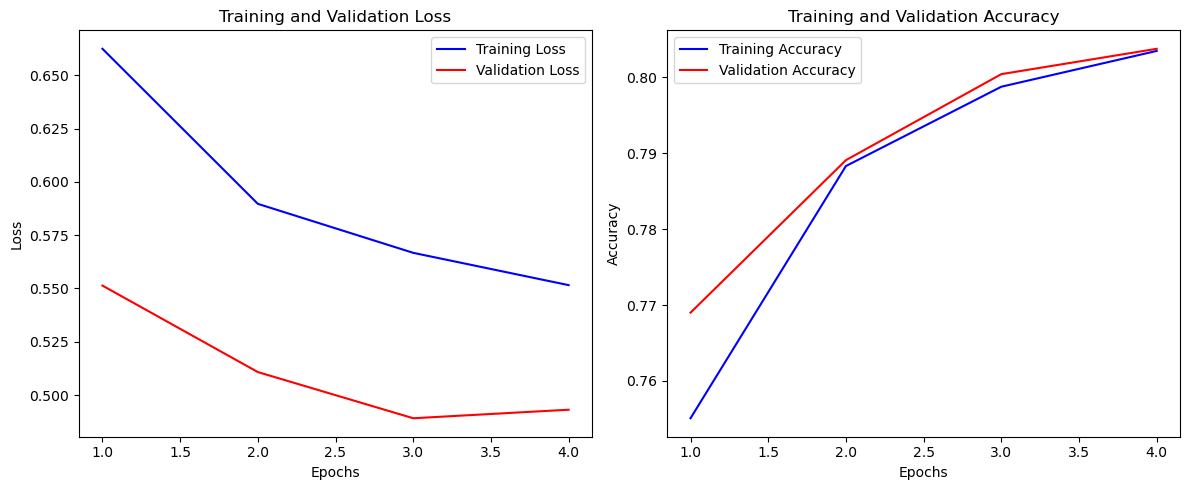

In [57]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Create a subplot for loss
plt.plot(epochs, train_loss_final, 'b', label='Training Loss')
plt.plot(epochs, val_loss_final, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)  # Create a subplot for accuracy
plt.plot(epochs, train_accuracy_final, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_final, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [58]:
# Evaluate the final model on the test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)

3615/3615 [==============================] - 28s 8ms/step - loss: 0.4894 - accuracy: 0.8047


# Evaluation

In [59]:
# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Extract the true labels from the 'Sentiment' columns in y_test
y_test_labels = y_test.iloc[:, -3:].values.argmax(axis=1)

# Extract the predicted labels from the 'Sentiment' columns in y_pred
y_pred_labels = y_pred[:, -3:].argmax(axis=1)

# Calculate the confusion matrix for multi-class classification
confusion = confusion_matrix(y_test_labels, y_pred_labels)

# Generate a classification report for multi-class classification
class_report = classification_report(y_test_labels, y_pred_labels, target_names=['Sentiment 0', 'Sentiment 1', 'Sentiment 2'])

3615/3615 [==============================] - 22s 6ms/step


In [60]:
# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(class_report)

Test Loss: 0.4894
Test Accuracy: 80.47%

Confusion Matrix:
[[ 7954  2146   348]
 [ 4399 11261  3808]
 [ 2505  9380 73859]]

Classification Report:
              precision    recall  f1-score   support

 Sentiment 0       0.54      0.76      0.63     10448
 Sentiment 1       0.49      0.58      0.53     19468
 Sentiment 2       0.95      0.86      0.90     85744

    accuracy                           0.80    115660
   macro avg       0.66      0.73      0.69    115660
weighted avg       0.83      0.80      0.82    115660



In [61]:
# Define the path where you want to save the model
model_save_path = "best_LSTM_model1.keras"

# Save the model to the specified path
final_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to best_LSTM_model1.keras


## Application

In [ ]:
# Load the LSTM model
best_model = load_model("best_LSTM_model1.keras")

In [ ]:
# Define the maximum number of words and maximum sequence length 
max_words = 10000
max_sequence_length = 20

# Create a Tokenizer for text preprocessing
tokenizer = Tokenizer(num_words=max_words)

# Create the main application window
app = tk.Tk()
app.title("Sentiment Analysis")

In [1]:
# Create a function to analyze sentiment when the button is clicked
def analyze_sentiment():
    text = text_entry.get("1.0", "end-1c")  # Get the text from the text box
    if not text:
        messagebox.showinfo("Error", "Please enter some text.")
        return

    # Disable the button and change its text during analysis
    analyze_button.config(text="Analyzing...", state="disabled")
    app.update()

    try:
        # Tokenize and pad the input text
        sequences = tokenizer.texts_to_sequences([text])
        X = pad_sequences(sequences, maxlen=max_sequence_length)

        # Predict sentiment using the model
        sentiment_scores = best_model.predict(X)
        sentiment_label = np.argmax(sentiment_scores)

        # Define the sentiment classes
        sentiment_classes = ["Negative", "Neutral", "Positive"]

        # Show the sentiment result in a message box
        result = sentiment_classes[sentiment_label]
        messagebox.showinfo("Sentiment Analysis Result", f"Sentiment: {result}")
    except Exception as e:
        messagebox.showinfo("Error", f"An error occurred: {str(e)}")
    finally:
        # Revert the button text and enable it
        analyze_button.config(text="Analyze Sentiment", state="normal")

# Create a label
label = tk.Label(app, text="Enter text to analyze sentiment:")
label.pack()

# Create a text entry box
text_entry = tk.Text(app, height=5, width=40)
text_entry.pack()

# Create a button to perform sentiment analysis
analyze_button = tk.Button(app, text="Analyze Sentiment", command=analyze_sentiment)
analyze_button.pack()

# Run the application
app.mainloop()

NameError: name 'load_model' is not defined

In [ ]:
# Create a tkinter window
root = tk.Tk()
root.withdraw()

# Show a message box
messagebox.showinfo("Message", "Thanks for reading!")

# Close the tkinter window
root.destroy()